<font size=6 color='purple'>**Main plotting script and data curation for paper (so far)**</font>

*Notes:* Initialization cells must be run before plotting, since they define colors and snapshot numbers


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
from utils.get_summary_data import compile_summary
from vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [16]:
plt.rcParams.update({'font.size':20})

# Initialization

In [15]:
palette = {"Illustris":"#668AFF","TNG": "#B6DAFF", # "TNG": "#7B55F3"
           "dark":"#044751","hydro": "#B6DAFF", 
           
           "Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC",
           
           "All Pairs":"#668AFF","Major Pairs": "#7B55F3",
           "Minor Pairs":'#FFB201',"Minor Plus Pairs":"#FF6300",
           
#            "Illustris dark":"#668AFF", "Illustris hydro": "#7B55F3",
#            "TNG dark": '#FFB201', "TNG hydro": "#FF6300",
           
           "Extra":"#DE2280","Stellar":"#0A68DD",
           "Halo":"#4B0094","Max Halo":"#FF6BB7"}
# alphaVal = {"Major":0.7,"Minor":0.4}
# style = {"dark":"dashed","hydro":"solid"}

In [4]:
zs = {"z":[0,1,2,3,4], "zill":[135,85,68,60,54], "ztng":[99,50,33,25,21]}

# Methods


## Counts

Counts of primaries and pairs as a function of time (tertiaries?)

### Dwarfs

In [28]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass
errorprint = False
redshiftcutoff_Ill = 3.8 
redshiftcutoff_TNG = 4
# need to use different redshift cuts cause 54 dne, and 53+55 hydro dne

In [29]:
## Make Illustris median count dataset

Illustris = {}
for it_phys in ['dark','hydro']:
    Illustris[it_phys] = {}
    z = []
    meds = []
    quarts = []
    meds_unpaired = []
    meds_pairs = []
    for snapnum in np.arange(0,136):
        if snapnum ==113:
            continue
            
        try:
            pair_path = f"Illustris_{snapnum}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            realarray = np.unique(np.array(pair_data['pairs']['dark']['Realization']))
            
            if len(pair_data['pairs']['dark']['Group ID']) == 0:
                raise EmptyFile
                
            if pair_data['Header'].attrs['Redshift'] > redshiftcutoff_Ill:
                raise SkipRedshift
                        
            num_prims_per_real = []
            num_unpaired_per_real = []
            num_pairs_per_real = []
            for realization in realarray:
                # find num of unpaired prims:
                unpaired_stells = np.array(pair_data['unpaired'][it_phys]['Sub1 Stellar Mass'])
                unpaired_realization = np.array(pair_data['unpaired'][it_phys]['Realization'])

                mask_prims = (unpaired_stells > 0.01) & (unpaired_stells < 0.5)
                mask_real = unpaired_realization == realization

                num_unpairedprims = np.count_nonzero(mask_real & mask_prims)
                num_unpaired_per_real.append(num_unpairedprims)

                # find num of paired prims:
                paired_stells = np.array(pair_data['pairs'][it_phys]['Sub1 Stellar Mass'])
                paired_realization = np.array(pair_data['pairs'][it_phys]['Realization'])

                mask_prims = (paired_stells > 0.01) & (paired_stells < 0.5)
                mask_real = paired_realization == realization

                num_pairedprims = np.count_nonzero(mask_real & mask_prims)
                num_pairs_per_real.append(num_pairedprims)

                # find total number of primaries
                tot_numprims = num_unpairedprims + num_pairedprims
                num_prims_per_real.append(tot_numprims)
                
            z.append(pair_data['Header'].attrs['Redshift'])
            meds.append( np.median(num_prims_per_real) )
            quarts.append( np.percentile(num_prims_per_real,[16,84]) )
            meds_unpaired.append( np.median(num_unpaired_per_real) )
            meds_pairs.append( np.median(num_pairs_per_real) )
            
            pair_data.close()
        
        except KeyError:
            if errorprint: print(f'skipping {snapnum}')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snapnum}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snapnum}, redshift out of range")
            
    Illustris[it_phys] = {"z":z, "medians":meds, "quartiles":quarts, "unpaired":meds_unpaired, "paired": meds_pairs}
            
    print(f"{it_phys} complete")



dark complete
hydro complete


In [30]:
## Make TNG median count dataset

TNG = {}
for it_phys in ['dark','hydro']:
    TNG[it_phys] = {}
    z = []
    meds = []
    quarts = []
    meds_unpaired = []
    meds_pairs = []
    for snapnum in np.arange(0,100):
        if snapnum ==48:
            continue
        try:
            pair_path = f"TNG_{snapnum}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            realarray = np.unique(np.array(pair_data['pairs'][it_phys]['Realization']))
            
            if len(pair_data['pairs']['dark']['Group ID']) == 0:
                raise EmptyFile
                
            if pair_data['Header'].attrs['Redshift'] > redshiftcutoff_TNG:
                raise SkipRedshift
            
            num_prims_per_real = []
            num_unpaired_per_real = []
            num_pairs_per_real = []
            for realization in realarray:
                # find num of unpaired prims:
                unpaired_stells = np.array(pair_data['unpaired'][it_phys]['Sub1 Stellar Mass'])
                unpaired_realization = np.array(pair_data['unpaired'][it_phys]['Realization'])

                mask_prims = (unpaired_stells > 0.01) & (unpaired_stells < 0.5)
                mask_real = unpaired_realization == realization

                num_unpairedprims = np.count_nonzero(mask_real & mask_prims)
                num_unpaired_per_real.append(num_unpairedprims)

                # find num of paired prims:
                paired_stells = np.array(pair_data['pairs'][it_phys]['Sub1 Stellar Mass'])
                paired_realization = np.array(pair_data['pairs'][it_phys]['Realization'])

                mask_prims = (paired_stells > 0.01) & (paired_stells < 0.5)
                mask_real = paired_realization == realization

                num_pairedprims = np.count_nonzero(mask_real & mask_prims)
                num_pairs_per_real.append(num_pairedprims)

                # find total number of primaries
                tot_numprims = num_unpairedprims + num_pairedprims
                num_prims_per_real.append(tot_numprims)

            z.append(pair_data['Header'].attrs['Redshift'])
            meds.append( np.median(num_prims_per_real) )
            quarts.append( np.percentile(num_prims_per_real,[16,84]) )
            meds_unpaired.append( np.median(num_unpaired_per_real) )
            meds_pairs.append( np.median(num_pairs_per_real) )
            
            pair_data.close()

        
        except KeyError:
            if errorprint: print(f'skipping {snapnum}')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snapnum}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snapnum}, redshift out of range")
            
    TNG[it_phys] = {"z":z, "medians":meds, "quartiles":quarts, "unpaired":meds_unpaired, "paired": meds_pairs}
            
    print(f"{it_phys} complete")



dark complete
hydro complete


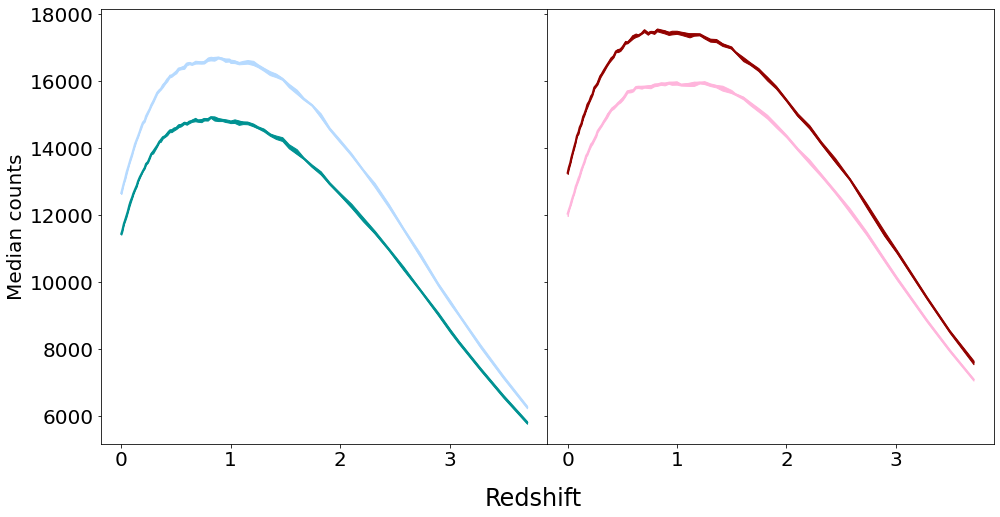

In [31]:
# plot of median counts for Illustris and TNG

fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
plt.subplots_adjust(wspace=0,hspace=0)

for phys in ["dark","hydro"]:

    sim = "Illustris"
    color = f"{sim} {phys}"
    
    ill = Illustris[phys]
    minus = np.array(ill['medians'])-np.array(ill['quartiles'])[:,0]
    plus = np.array(ill['quartiles'])[:,1] - np.array(ill['medians'])
    ax[0].plot(ill['z'],ill['medians'], color=palette[color], lw=2)
    ax[0].fill_between(ill['z'], np.array(ill['quartiles'])[:,0], np.array(ill['quartiles'])[:,1],color=palette[color],alpha=1)
    
    sim = "TNG"
    color = f"{sim} {phys}"
    
    tng = TNG[phys]
    minus = np.array(tng['medians'])-np.array(tng['quartiles'])[:,0]
    plus = np.array(tng['quartiles'])[:,1] - np.array(tng['medians'])
    
    
    ax[1].plot(tng['z'],tng['medians'], color=palette[color], lw=2)
    ax[1].fill_between(tng['z'], np.array(tng['quartiles'])[:,0], np.array(tng['quartiles'])[:,1],color=palette[color],alpha=1)


# plt.savefig(f"../plots/pairs_plots/{size}_{subset}_sepvsvel.pdf",bbox_inches='tight')
fig.supxlabel('Redshift')
ax[0].set_ylabel('Median counts')
plt.show()

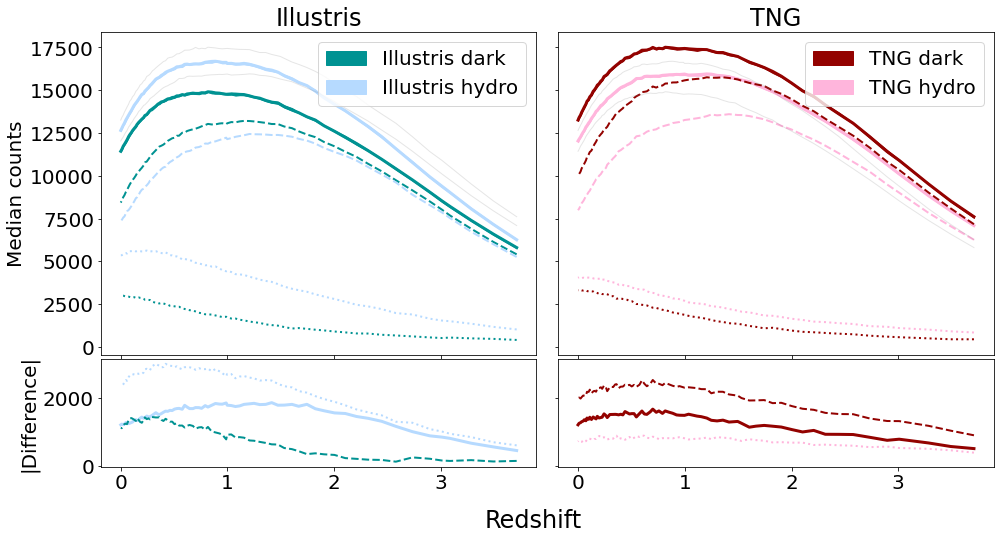

In [33]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

illd, illh = Illustris['dark'], Illustris['hydro']
tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)


########################
# Illustris difference #
########################
axilldiff.set(ylabel="|Difference|")

axilldiff.plot(illd['z'], np.abs( np.array(illd['medians'])-np.array(illh['medians']) ), color=palette["Illustris hydro"], lw=3)
axilldiff.plot(illd['z'], np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) ), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], np.abs( np.array(illd['paired'])-np.array(illh['paired']) ), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) ), color=palette["TNG dark"], lw=3)
axtngdiff.plot(tngd['z'], np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) ), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) ), color=palette["TNG dark"], lw=2, linestyle='dashed')

axILL.legend(loc="upper right")
axTNG.legend(loc="upper right")
fig.supxlabel("Redshift")
# axilldiff.legend(loc="lower left")
# axtngdiff.legend(loc="lower left")
plt.savefig(f"../plots/pairs_plots/counts_dwarfs.png",bbox_inches='tight',facecolor="white")
plt.show()


### Massive

In [34]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass
errorprint = False
redshiftcutoff_Ill = 3.8 
redshiftcutoff_TNG = 4
# need to use different redshift cuts cause 54 dne, and 53+55 hydro dne

In [35]:
## Make Illustris massive median count dataset

Illustris = {}
for it_phys in ['dark','hydro']:
    Illustris[it_phys] = {}
    z = []
    meds = []
    quarts = []
    meds_unpaired = []
    meds_pairs = []
    for snapnum in np.arange(0,136):
        if snapnum ==113:
            continue
            
        try:
            pair_path = f"Illustris_{snapnum}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            realarray = np.unique(np.array(pair_data['pairs']['dark']['Realization']))
            
            if len(pair_data['pairs']['dark']['Group ID']) == 0:
                raise EmptyFile
                
            if pair_data['Header'].attrs['Redshift'] > redshiftcutoff_Ill:
                raise SkipRedshift
                        
            num_prims_per_real = []
            num_unpaired_per_real = []
            num_pairs_per_real = []
            for realization in realarray:
                # find num of unpaired prims:
                unpaired_stells = np.array(pair_data['unpaired'][it_phys]['Sub1 Stellar Mass'])
                unpaired_realization = np.array(pair_data['unpaired'][it_phys]['Realization'])

                mask_prims = (unpaired_stells > 0.5) & (unpaired_stells < 10)
                mask_real = unpaired_realization == realization

                num_unpairedprims = np.count_nonzero(mask_real & mask_prims)
                num_unpaired_per_real.append(num_unpairedprims)

                # find num of paired prims:
                paired_stells = np.array(pair_data['pairs'][it_phys]['Sub1 Stellar Mass'])
                paired_realization = np.array(pair_data['pairs'][it_phys]['Realization'])

                mask_prims = (paired_stells > 0.5) & (paired_stells < 10)
                mask_real = paired_realization == realization

                num_pairedprims = np.count_nonzero(mask_real & mask_prims)
                num_pairs_per_real.append(num_pairedprims)


                # find total number of primaries
                tot_numprims = num_unpairedprims + num_pairedprims
                num_prims_per_real.append(tot_numprims)

            z.append(pair_data['Header'].attrs['Redshift'])
            meds.append( np.median(num_prims_per_real) )
            quarts.append( np.percentile(num_prims_per_real,[16,84]) )
            meds_unpaired.append( np.median(num_unpaired_per_real) )
            meds_pairs.append( np.median(num_pairs_per_real) )
            
            pair_data.close()
        
        except KeyError:
            if errorprint: print(f'skipping {snapnum}')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snapnum}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snapnum}, redshift out of range")
            
    Illustris[it_phys] = {"z":z, "medians":meds, "quartiles":quarts, "unpaired":meds_unpaired, "paired": meds_pairs}
    print(f"{it_phys} complete")



dark complete
hydro complete


In [36]:
## Make TNG median count dataset

TNG = {}
for it_phys in ['dark','hydro']:
    TNG[it_phys] = {}
    z = []
    meds = []
    quarts = []
    meds_unpaired = []
    meds_pairs = []
    for snapnum in np.arange(0,100):
        if snapnum ==48:
            continue
        try:
            pair_path = f"TNG_{snapnum}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            realarray = np.unique(np.array(pair_data['pairs'][it_phys]['Realization']))
            
            if len(pair_data['pairs']['dark']['Group ID']) == 0:
                raise EmptyFile
                
            if pair_data['Header'].attrs['Redshift'] > redshiftcutoff_TNG:
                raise SkipRedshift
            
            num_prims_per_real = []
            num_unpaired_per_real = []
            num_pairs_per_real = []
            for realization in realarray:
                # find num of unpaired prims:
                unpaired_stells = np.array(pair_data['unpaired'][it_phys]['Sub1 Stellar Mass'])
                unpaired_realization = np.array(pair_data['unpaired'][it_phys]['Realization'])

                mask_prims = (unpaired_stells > 0.5) & (unpaired_stells < 10)
                mask_real = unpaired_realization == realization

                num_unpairedprims = np.count_nonzero(mask_real & mask_prims)
                num_unpaired_per_real.append(num_unpairedprims)

                # find num of paired prims:
                paired_stells = np.array(pair_data['pairs'][it_phys]['Sub1 Stellar Mass'])
                paired_realization = np.array(pair_data['pairs'][it_phys]['Realization'])

                mask_prims = (paired_stells > 0.5) & (paired_stells < 10)
                mask_real = paired_realization == realization

                num_pairedprims = np.count_nonzero(mask_real & mask_prims)
                num_pairs_per_real.append(num_pairedprims)

                # find total number of primaries
                tot_numprims = num_unpairedprims + num_pairedprims
                num_prims_per_real.append(tot_numprims)
                

            z.append(pair_data['Header'].attrs['Redshift'])
            meds.append( np.median(num_prims_per_real) )
            quarts.append( np.percentile(num_prims_per_real,[16,84]) )
            meds_unpaired.append( np.median(num_unpaired_per_real) )
            meds_pairs.append( np.median(num_pairs_per_real) )
            
            pair_data.close()

        
        except KeyError:
            if errorprint: print(f'skipping {snapnum}')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snapnum}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snapnum}, redshift out of range")
            
    TNG[it_phys] = {"z":z, "medians":meds, "quartiles":quarts, "unpaired":meds_unpaired, "paired": meds_pairs}
            
    print(f"{it_phys} complete")



dark complete
hydro complete


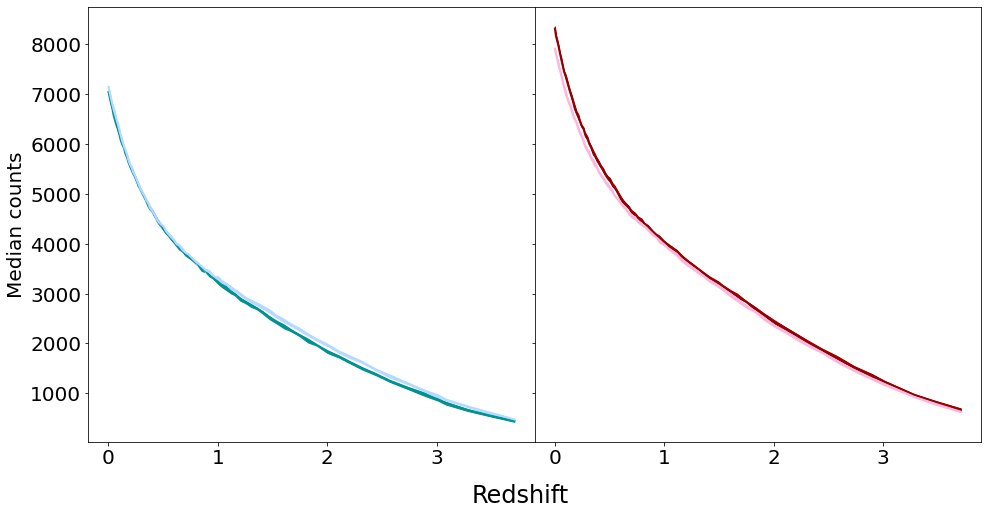

In [37]:
# plot of median counts for Illustris and TNG

fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
plt.subplots_adjust(wspace=0,hspace=0)

for phys in ["dark","hydro"]:

    sim = "Illustris"
    color = f"{sim} {phys}"
    
    ill = Illustris[phys]
    ax[0].plot(ill['z'],ill['medians'], color=palette[color], lw=2)
    ax[0].fill_between(ill['z'], np.array(ill['quartiles'])[:,0], np.array(ill['quartiles'])[:,1],color=palette[color],alpha=1)
    
    sim = "TNG"
    color = f"{sim} {phys}"
    
    tng = TNG[phys]
    ax[1].plot(tng['z'],tng['medians'], color=palette[color], lw=2)
    ax[1].fill_between(tng['z'], np.array(tng['quartiles'])[:,0], np.array(tng['quartiles'])[:,1],color=palette[color],alpha=1)

fig.supxlabel('Redshift')
ax[0].set_ylabel('Median counts')
plt.show()

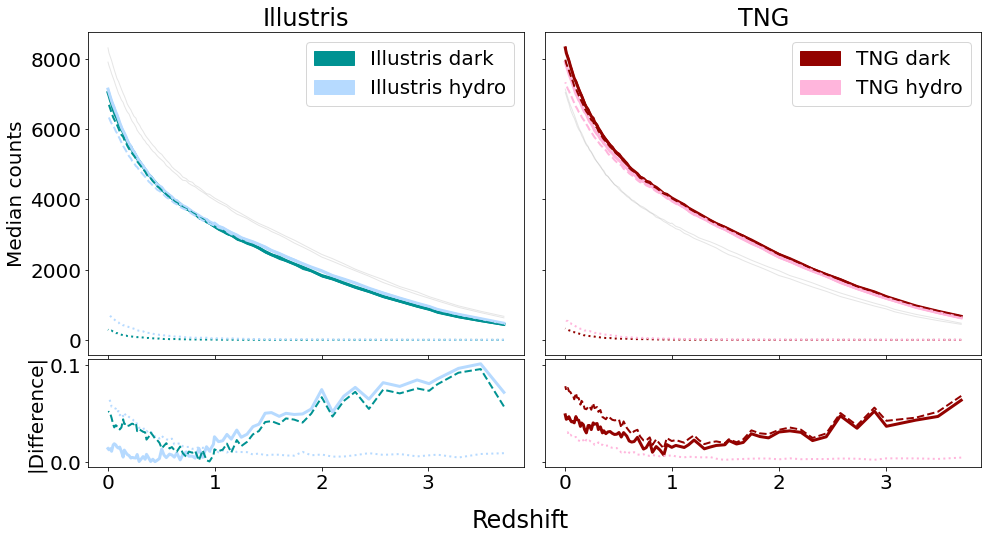

In [46]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

illd, illh = Illustris['dark'], Illustris['hydro']
tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)


########################
# Illustris difference #
########################
axilldiff.set(ylabel="|Difference|")

axilldiff.plot(illd['z'], np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/illd['medians'], color=palette["Illustris hydro"], lw=3)
axilldiff.plot(illd['z'], np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/illd['medians'], color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/illd['medians'], color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], (np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/tngd['medians']), color=palette["TNG dark"], lw=3)
axtngdiff.plot(tngd['z'], (np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/tngd['medians']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], (np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/tngd['medians']), color=palette["TNG dark"], lw=2, linestyle='dashed')

axILL.legend(loc="upper right")
axTNG.legend(loc="upper right")
fig.supxlabel("Redshift")
# axilldiff.legend(loc="lower left")
# axtngdiff.legend(loc="lower left")
# plt.savefig(f"../plots/pairs_plots/counts_massive.png",bbox_inches='tight',facecolor="white")
plt.show()


## Distributions


In [ ]:
inst = compile_summary(sim=it_sim, phys=it_phys, size=size, subset=it_subset)
data_summary = inst.get_snapshot(snapnum=snapnum)
# create mask to get median stellar mass results
        mask = data_summary["Realization"]==-1
        seps = data_summary["Separation"]
        vels = data_summary["RelVel"]